# Import libraries

In [1]:
import requests
import json
import os
import matplotlib.pyplot as plt
from shapely.geometry import shape, MultiPolygon, Polygon
import pandas as pd
import geopandas as gpd
from shapely import wkt
from pandas.api.types import is_object_dtype
from pandas.api.types import CategoricalDtype
import numpy as np

# Read Datasets

In [2]:
la_trees_fire_unique_grouped = pd.read_csv("/Users/davidliu/Desktop/IASC-2025/data/la_trees_fire_unique_grouped.csv")
la_trees_fire_temp = pd.read_csv("/Users/davidliu/Desktop/IASC-2025/data/la_trees_fire_temp.csv")

# Visualized the tree density in LA

In [3]:
la_trees_fire_temp.shape

(51896, 24)

In [4]:
la_trees_fire_temp.columns

Index(['Latitude', 'Longitude', 'Species', 'DBH', 'Any_Protected', 'tree_id',
       'geometry', 'index_right', 'OBJECTID', 'YEAR_', 'STATE', 'AGENCY',
       'UNIT_ID', 'FIRE_NAME', 'CAUSE', 'GIS_ACRES', 'DECADES', 'Shape__Area',
       'Shape__Length', 'tree_appear_count', 'FIRE_SIZE_CATEGORY',
       'USDA_FIRE_SIZE_CLASS', 'TreeGroup', 'Annual_Temp'],
      dtype='object')

In [5]:
drop_columns = ['tree_id', 'geometry', 'FIRE_NAME', 'index_right', 'UNIT_ID', 'DECADES', 'USDA_FIRE_SIZE_CLASS','Species', 'GIS_ACRES','Shape__Area', 'Shape__Length','STATE', "AGENCY", "Any_Protected"]
la_trees_fire_model = la_trees_fire_temp.drop(columns=drop_columns)

In [6]:
la_trees_fire_model

,Latitude,Longitude,DBH,OBJECTID,YEAR_,CAUSE,tree_appear_count,FIRE_SIZE_CATEGORY,TreeGroup,Annual_Temp
0,34.154814,-118.589896,25.0,18164,1944.0,14,1,Large,Oak,62.2
1,34.154815,-118.589929,13.0,18164,1944.0,14,1,Large,Oak,62.2
2,34.275480,-118.541392,0.0,15798,1959.0,14,2,Medium,Myla311,67.3
3,34.145944,-118.505713,0.0,15674,1960.0,14,1,Small,Myla311,65.6
4,34.089382,-118.452487,10.0,15426,1961.0,14,1,Large,Oak,65.3
...,...,...,...,...,...,...,...,...,...,...
51891,34.281985,-118.524873,1.0,17827,1947.0,14,1,Medium,Eucalyptus,64.1
51892,34.281909,-118.524855,1.0,17827,1947.0,14,1,Medium,Oak,64.1
51893,34.281829,-118.524832,1.0,17827,1947.0,14,1,Medium,Oak,64.1
51894,34.281753,-118.524804,1.0,17827,1947.0,14,1,Medium,Oak,64.1


# Model - Random Forest

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [18]:
# Define features and target
X = la_trees_fire_model[['Latitude', 'Longitude','DBH', 'CAUSE', 'tree_appear_count', 'TreeGroup']]
y = la_trees_fire_model['FIRE_SIZE_CATEGORY']

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y_encoded)

# Preprocessing for numeric and categorical features
numeric_features = [ 'Latitude', 'Longitude', 'DBH', 'tree_appear_count']
categorical_features = ['CAUSE', 'TreeGroup']

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Create a pipeline with a Random Forest classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred = pipeline.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Classification Report:
              precision    recall  f1-score   support

       Large       0.98      0.98      0.98      1917
      Medium       0.98      0.99      0.99      4073
       Small       0.98      0.94      0.96       910
  Very Large       0.99      0.99      0.99      3480

    accuracy                           0.99     10380
   macro avg       0.98      0.98      0.98     10380
weighted avg       0.99      0.99      0.99     10380



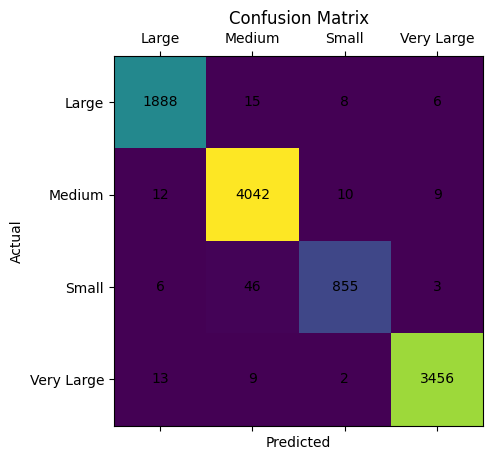

In [19]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots()
cax = ax.matshow(cm)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_xticks(range(len(le.classes_)))
ax.set_yticks(range(len(le.classes_)))
ax.set_xticklabels(le.classes_)
ax.set_yticklabels(le.classes_)
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, val, ha='center', va='center')
plt.show()

In [20]:
import numpy as np

feature_names_num = numeric_features
feature_names_cat = pipeline.named_steps['preprocessor'] \
    .named_transformers_['cat'] \
    .get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([feature_names_num, feature_names_cat])

importances = pipeline.named_steps['classifier'].feature_importances_
feat_imp = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

In [21]:
feat_imp.iloc[0:20]

,feature,importance
1,Longitude,0.392917
0,Latitude,0.324594
3,tree_appear_count,0.056319
7,CAUSE_11,0.039128
2,DBH,0.035737
8,CAUSE_14,0.031317
4,CAUSE_3,0.027617
69,TreeGroup_Oak,0.007961
43,TreeGroup_Eucalyptus,0.007396
52,TreeGroup_Juglans,0.005623


# Model - XGBoost

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

# Define features and target
X = la_trees_fire_model[[ 'Latitude', 'Longitude', 'DBH', 'CAUSE', 'tree_appear_count', 'TreeGroup']]
y = la_trees_fire_model['FIRE_SIZE_CATEGORY']

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Preprocessing steps
numeric_features = [ 'Latitude', 'Longitude','DBH', 'tree_appear_count']
categorical_features = ['CAUSE', 'TreeGroup']

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Create a pipeline with a Gradient Boosting classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Train the boosting model
pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred = pipeline.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Extract feature importances
import numpy as np

feature_names_num = numeric_features
feature_names_cat = pipeline.named_steps['preprocessor'] \
    .named_transformers_['cat'] \
    .get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([feature_names_num, feature_names_cat])

importances = pipeline.named_steps['classifier'].feature_importances_
feat_imp = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)


Classification Report:
              precision    recall  f1-score   support

       Large       0.92      0.95      0.93      1917
      Medium       0.95      0.97      0.96      4073
       Small       0.98      0.78      0.87       910
  Very Large       0.98      0.98      0.98      3480

    accuracy                           0.96     10380
   macro avg       0.96      0.92      0.94     10380
weighted avg       0.96      0.96      0.95     10380



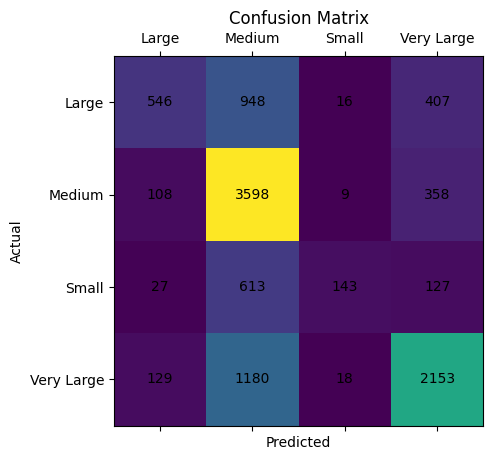

In [15]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots()
cax = ax.matshow(cm)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_xticks(range(len(le.classes_)))
ax.set_yticks(range(len(le.classes_)))
ax.set_xticklabels(le.classes_)
ax.set_yticklabels(le.classes_)
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, val, ha='center', va='center')
plt.show()

In [16]:
feat_imp.iloc[0:20]

,feature,importance
5,CAUSE_11,0.229961
2,CAUSE_3,0.213204
1,tree_appear_count,0.167017
6,CAUSE_14,0.099690
0,DBH,0.045435
67,TreeGroup_Oak,0.032489
50,TreeGroup_Juglans,0.031597
4,CAUSE_7,0.020574
88,TreeGroup_Sweetgum,0.017975
41,TreeGroup_Eucalyptus,0.016699


# Multinomial Logistic Regression

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: invalid value encountered in matmul
  r

Multinomial Logistic Regression Results:

Classification Report:
              precision    recall  f1-score   support

       Large       0.53      0.47      0.49      1917
      Medium       0.73      0.84      0.78      4073
       Small       0.55      0.15      0.24       910
  Very Large       0.81      0.86      0.83      3480

    accuracy                           0.72     10380
   macro avg       0.65      0.58      0.59     10380
weighted avg       0.70      0.72      0.70     10380



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


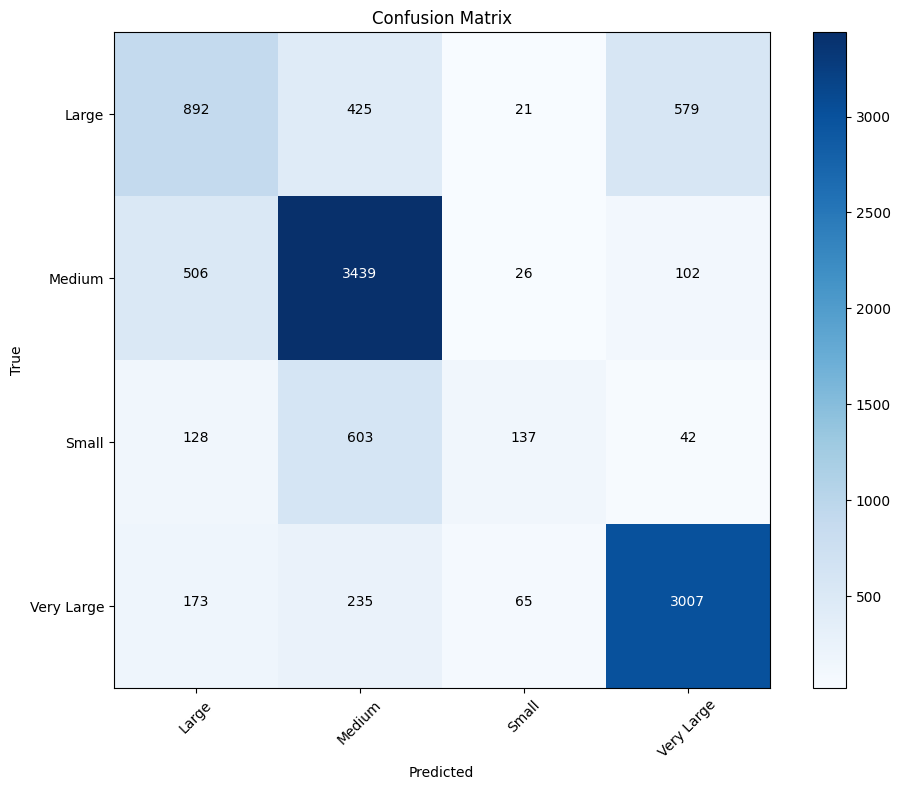


Top 10 Most Important Features:
                   feature  importance
8                 CAUSE_11    1.509049
5                  CAUSE_3    1.443424
91      TreeGroup_Sweetgum    1.389874
7                  CAUSE_7    1.286342
50  TreeGroup_Handroanthus    0.900663
1                Longitude    0.823938
48     TreeGroup_Gleditsia    0.779243
53       TreeGroup_Juglans    0.746662
9                 CAUSE_14    0.697780
76      TreeGroup_Pistacia    0.691949

Overall Accuracy: 0.7201


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [16]:
# Multinomial Logistic Regression with scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Prepare features and target
X = la_trees_fire_model[['Latitude', 'Longitude', 'DBH', 'YEAR_', 'CAUSE', 'tree_appear_count', 'TreeGroup']]
y = la_trees_fire_model['FIRE_SIZE_CATEGORY']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocessing steps
numeric_features = ['Latitude', 'Longitude', 'DBH', 'YEAR_', 'tree_appear_count']
categorical_features = ['CAUSE', 'TreeGroup']

# Create preprocessor with proper OneHotEncoder settings
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# Create pipeline with preprocessing and logistic regression
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        C=0.1,  # Inverse of regularization strength
        random_state=42
    ))
])

# Fit the model
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Print classification report
print("Multinomial Logistic Regression Results:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels
classes = sorted(y.unique())
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted')
plt.ylabel('True')

# Add numbers inside the plot
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Get feature names after one-hot encoding
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
feature_names = np.concatenate([numeric_features, cat_feature_names])

# Get coefficients (average absolute values across classes)
importances = np.abs(clf.named_steps['classifier'].coef_).mean(axis=0)
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Print model accuracy
accuracy = clf.score(X_test, y_test)
print(f"\nOverall Accuracy: {accuracy:.4f}")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: invalid value encountered in matmul
  r

Tree Species Effects on Fire Prevention:

Interpretation:
- Values > 1: Species associated with increased fire risk
- Values < 1: Species associated with decreased fire risk
- Overall Prevention Score > 1: Better at preventing fires

Top 15 Species for Fire Prevention:
                             Species  Avg_Effect_on_Small_Fires  \
TreeGroup_Juglans            Juglans                      2.957   
TreeGroup_Zelkova            Zelkova                      0.950   
TreeGroup_Searsia            Searsia                      3.404   
TreeGroup_Pistacia          Pistacia                      3.990   
TreeGroup_Ash                    Ash                      2.175   
TreeGroup_Morus                Morus                      0.961   
TreeGroup_Casuarina        Casuarina                      0.798   
TreeGroup_Tipuana            Tipuana                      1.199   
TreeGroup_Grevillea        Grevillea                      2.949   
TreeGroup_Eucalyptus      Eucalyptus                      1.

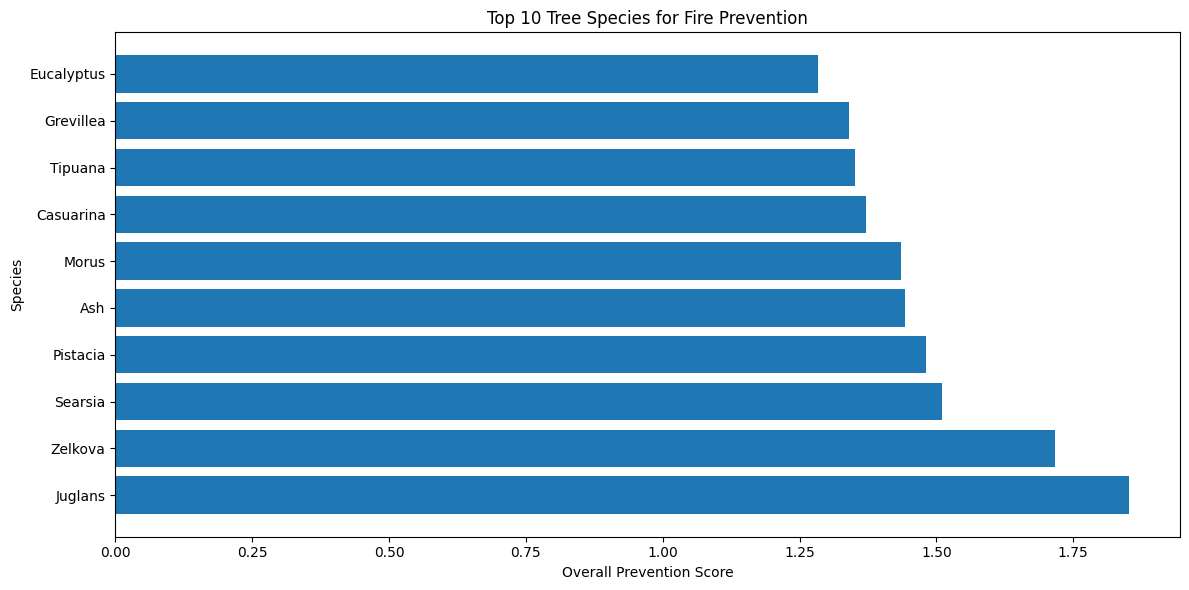


Detailed Statistics for Top 5 Species:

Juglans:
  Small Fire Effect: 2.957
  Medium Fire Effect: 1.506
  Large Fire Effect: 0.798
  Very Large Fire Effect: 0.281
  Overall Prevention Score: 1.853

Zelkova:
  Small Fire Effect: 0.950
  Medium Fire Effect: 3.122
  Large Fire Effect: 0.627
  Very Large Fire Effect: 0.538
  Overall Prevention Score: 1.717

Searsia:
  Small Fire Effect: 3.404
  Medium Fire Effect: 0.804
  Large Fire Effect: 0.933
  Very Large Fire Effect: 0.392
  Overall Prevention Score: 1.509

Pistacia:
  Small Fire Effect: 3.990
  Medium Fire Effect: 0.566
  Large Fire Effect: 0.787
  Very Large Fire Effect: 0.563
  Overall Prevention Score: 1.482

Ash:
  Small Fire Effect: 2.175
  Medium Fire Effect: 1.026
  Large Fire Effect: 0.875
  Very Large Fire Effect: 0.512
  Overall Prevention Score: 1.442


In [17]:
# Multinomial Logistic Regression with interpretable odds ratios
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Prepare features and target
X = la_trees_fire_model[['Latitude', 'Longitude', 'DBH', 'YEAR_', 'CAUSE', 'tree_appear_count', 'TreeGroup']]
y = la_trees_fire_model['FIRE_SIZE_CATEGORY']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocessing steps
numeric_features = ['Latitude', 'Longitude', 'DBH', 'YEAR_', 'tree_appear_count']
categorical_features = ['CAUSE', 'TreeGroup']

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ]
)

# Create pipeline
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        C=0.1,
        random_state=42
    ))
])

# Fit the model
clf.fit(X_train, y_train)

# Get feature names after preprocessing
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
feature_names = np.concatenate([numeric_features, cat_feature_names])

# Get coefficients and convert to odds ratios
coefficients = clf.named_steps['classifier'].coef_
odds_ratios = np.exp(coefficients)

# Create a DataFrame with odds ratios for each fire size category
fire_categories = sorted(y.unique())
odds_ratio_df = pd.DataFrame(
    odds_ratios,
    columns=feature_names,
    index=[f'{cat} vs Others' for cat in fire_categories]
)

# Filter for TreeGroup features only
tree_features = [col for col in odds_ratio_df.columns if 'TreeGroup' in col]
tree_odds_ratios = odds_ratio_df[tree_features]

# Calculate average effect across all fire size categories
avg_tree_effect = pd.DataFrame({
    'Species': [col.replace('TreeGroup_', '') for col in tree_features],
    'Avg_Effect_on_Small_Fires': odds_ratio_df.loc['Small vs Others', tree_features],
    'Avg_Effect_on_Medium_Fires': odds_ratio_df.loc['Medium vs Others', tree_features],
    'Avg_Effect_on_Large_Fires': odds_ratio_df.loc['Large vs Others', tree_features],
    'Avg_Effect_on_Very_Large_Fires': odds_ratio_df.loc['Very Large vs Others', tree_features]
})

# Sort by average effect on preventing large fires (values < 1 indicate fire prevention)
avg_tree_effect['Overall_Prevention_Score'] = 1 / avg_tree_effect[['Avg_Effect_on_Large_Fires', 'Avg_Effect_on_Very_Large_Fires']].mean(axis=1)
avg_tree_effect = avg_tree_effect.sort_values('Overall_Prevention_Score', ascending=False)

print("Tree Species Effects on Fire Prevention:")
print("\nInterpretation:")
print("- Values > 1: Species associated with increased fire risk")
print("- Values < 1: Species associated with decreased fire risk")
print("- Overall Prevention Score > 1: Better at preventing fires")
print("\nTop 15 Species for Fire Prevention:")
print(avg_tree_effect.head(15).round(3))

# Visualize top 10 species for fire prevention
plt.figure(figsize=(12, 6))
top_10_species = avg_tree_effect.head(10)
plt.barh(top_10_species['Species'], top_10_species['Overall_Prevention_Score'])
plt.title('Top 10 Tree Species for Fire Prevention')
plt.xlabel('Overall Prevention Score')
plt.ylabel('Species')
plt.tight_layout()
plt.show()

# Print additional statistics
print("\nDetailed Statistics for Top 5 Species:")
for _, row in avg_tree_effect.head(5).iterrows():
    print(f"\n{row['Species']}:")
    print(f"  Small Fire Effect: {row['Avg_Effect_on_Small_Fires']:.3f}")
    print(f"  Medium Fire Effect: {row['Avg_Effect_on_Medium_Fires']:.3f}")
    print(f"  Large Fire Effect: {row['Avg_Effect_on_Large_Fires']:.3f}")
    print(f"  Very Large Fire Effect: {row['Avg_Effect_on_Very_Large_Fires']:.3f}")
    print(f"  Overall Prevention Score: {row['Overall_Prevention_Score']:.3f}")